In [53]:
from flask import Flask, request, redirect, url_for,send_from_directory, render_template_string
from werkzeug.utils import secure_filename
import caffe
import json
import numpy as np
import os
from sklearn import svm,metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import struct
import pandas as pd

Train: 2182 Test:243
Ratio: 9:1

In [2]:
deployPrototxt = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/deploy.prototxt"
caffeModel = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
featureVectorDirectory = "/opt/swm-ml-docker/data/train"
metadataDirectory = '/opt/swm-ml-docker/metadata_bak/'
imageMeanFile = '/opt/swm-ml-docker/ilsvrc_2012_mean.npy'
layerName = 'fc7'

In [3]:
print("Loading model ...")
cnn = caffe.Net(deployPrototxt, caffe.TEST, weights=caffeModel)
print("Done loading")

Loading model ...
Done loading


In [4]:
# reshape to accept one image at a time.
(_, c, w, h) = cnn.blobs['data'].data.shape
cnn.blobs['data'].reshape(1, c, w, h)
transformer = caffe.io.Transformer({'data': cnn.blobs['data'].data.shape})
transformer.set_mean('data', np.load(imageMeanFile).mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)

In [5]:
def loadFeatureVectors(dirPath, d):
    """
    Loads all feature vectors from the local directory into a single nxd matrix
    where n is the number of feature vectors and the d is the dimensionality.
    Returns the matrix and a list of file names in one-to-one correspondence
    with the rows of the matrix.
    """
    allFiles = os.listdir(dirPath)
    data = np.zeros([len(allFiles), d])
    for i, fileName in enumerate(allFiles):
        with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
            data[i] = struct.unpack('f'*d, inputFile.read())
    return (data, allFiles)

def loadMetaData(metadataDir):
    metadataByImageHash = {}
    allFiles = os.listdir(metadataDir)
    for fileName in allFiles:
        with open("%s/%s" % (metadataDir, fileName), "r") as jsonFile:
            metadata = json.load(jsonFile)
            metadataByImageHash[metadata['Image Hash']] = metadata
    return metadataByImageHash

# Simple case
def makeBinaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(1 if (metadata['Secondary'] == "NA") else 0)
    return labels

In [6]:
print("Training SVM")
data, allImageHashes = loadFeatureVectors(featureVectorDirectory, d = 4096)
metadataByImageHash = loadMetaData(metadataDirectory)
labels = makeBinaryLabels(metadataByImageHash, allImageHashes)
clf = svm.SVC(probability=True)
clf.fit(data, labels)
print("Finished training ready to classify images")

Training SVM
Finished training ready to classify images


In [7]:
featureVectorTestDirectory = "/opt/swm-ml-docker/data/test"
dataTest, allImageHashesTest = loadFeatureVectors(featureVectorTestDirectory, d = 4096)
labelsTest = makeBinaryLabels(metadataByImageHash, allImageHashesTest)

In [8]:
clf.score(dataTest,labelsTest)

0.80246913580246915

In [9]:
prediction=clf.predict(dataTest)

In [12]:
CM = metrics.confusion_matrix(labelsTest,prediction)

In [13]:
print CM

[[ 70  36]
 [ 12 125]]


In [14]:
fpr,tpr,thesholds=metrics.roc_curve(labelsTest,prediction)

In [15]:
%%bash
caffe --version

caffe version 1.0.0


# False Positive Analysis

In [ ]:
i=0
file=open("FP.txt",'w')
while i<len(prediction):
    if prediction[i]==1 and labelsTest[i]==0:
        file.write(str(i))
        file.write('\n')
    i=i+1
file.close()        
        

In [39]:
filepath1="/opt/swm-ml-docker/data/test.txt"
filepath2="/opt/swm-ml-docker/data/FP.txt"
file=open("FP_imageName.txt",'w')
l=[]
with open(filepath2,'r') as fp:
    for line in fp:
        l.append(int(line))

i=0
FPImageHashes=[]
with open(filepath1,'r') as fp:
    for line in fp:
        if i in l:
            line = line.strip('\n')
            file.write(line+".jpg")
            file.write('\n')
            FPImageHashes.append(line)
        i=i+1
file.close()               
       

In [40]:
imageName=[]
file=open("imageNameFP.txt",'w')
for i in FPImageHashes:
    metadata=metadataByImageHash[i]
    file.write(metadata["Image Name"])
    file.write('\n')
file.close()

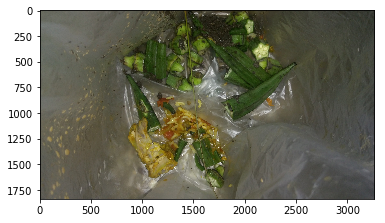

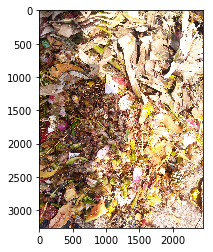

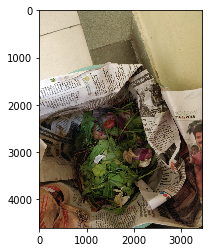

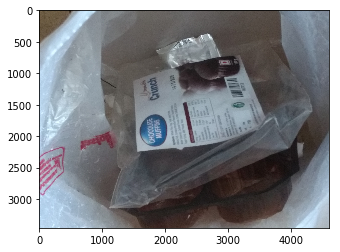

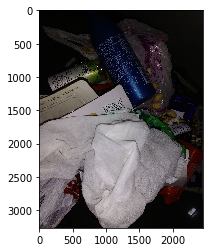

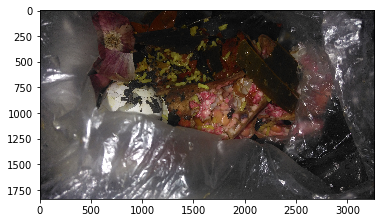

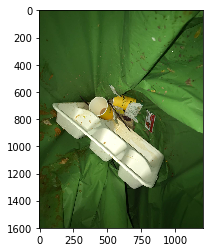

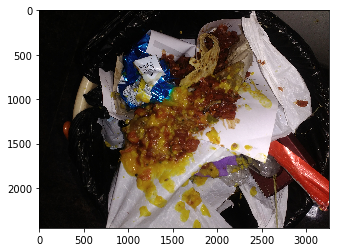

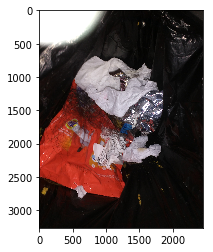

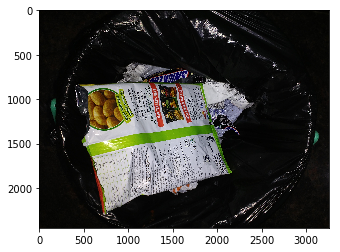

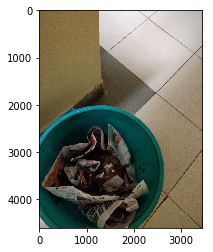

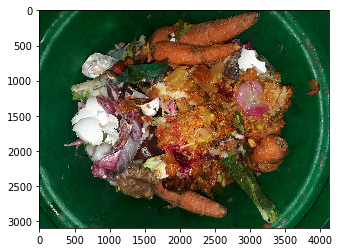

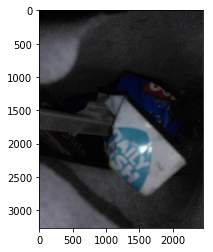

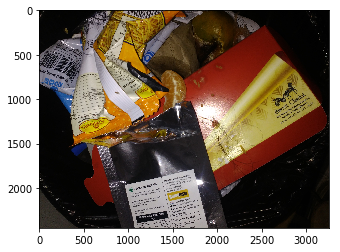

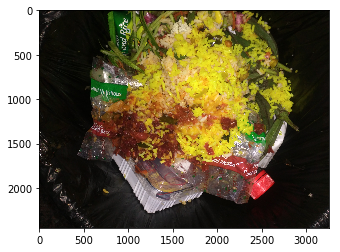

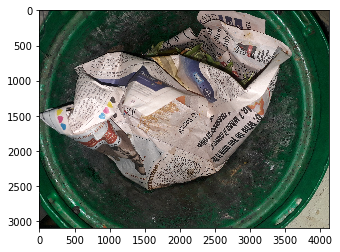

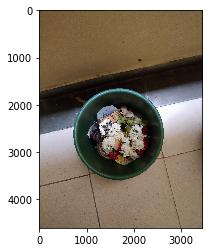

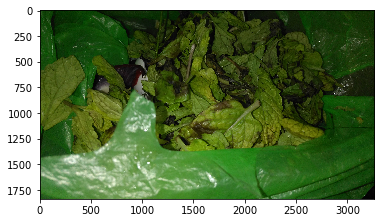

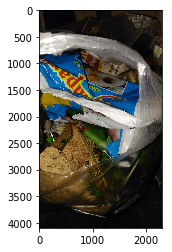

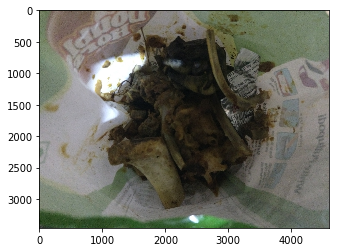

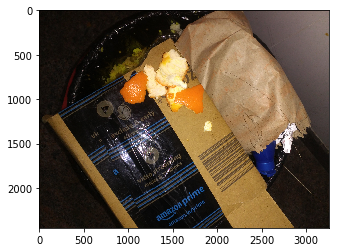

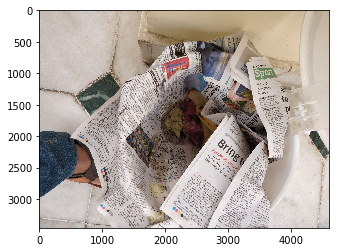

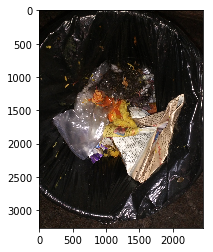

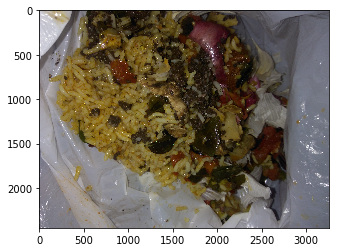

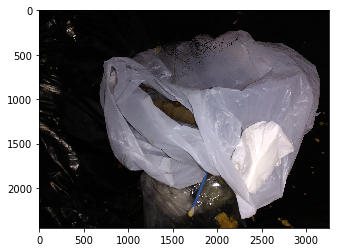

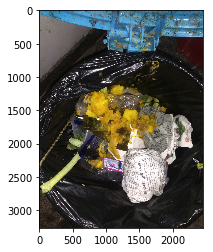

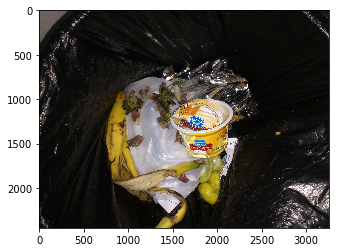

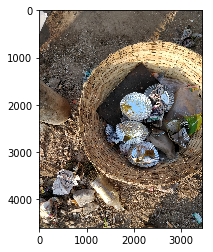

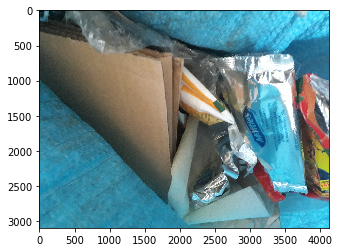

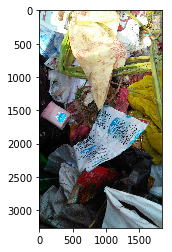

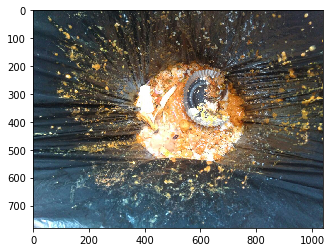

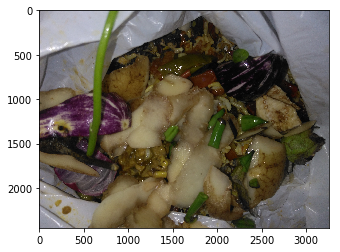

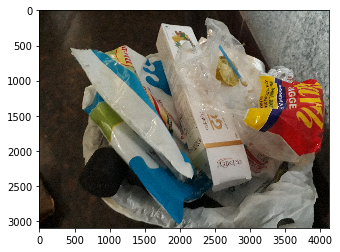

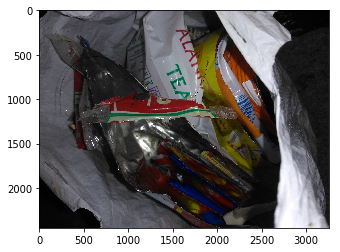

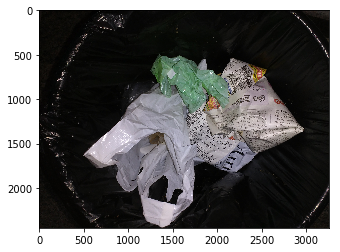

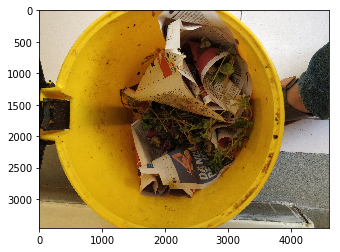

In [41]:
filepath="/opt/swm-ml-docker/images_bak/"
for i in FPImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

In [52]:
%%bash
ls

Consolidated.csv
FN.txt
FN_imageName.txt
FP.txt
FP_imageName.txt
exp-and.ipynb
exp1.ipynb
imageName.txt
imageNameFN.txt
imageNameFP.txt
svm_exp1_2425.pkl


In [55]:
df = pd.read_csv('Consolidated.csv')
filepath='imageNameFP.txt'
imageName=[]
with open(filepath,'r') as fp:
   for line in fp:
     line =line.strip('\n')
     imageName.append(line)
#print imageName
print df.loc[df['Image Name'].isin(imageName)]


      Serial No Primary Secondary Tertiary              Source Photographer  \
86           87     Dry       NaN      NaN               House      Watsapp   
374         375     Dry       Wet      NaN               House      Pravada   
407         408     Dry    Reject      Wet               House      Pravada   
466         467     Dry       Wet      NaN               House      Pravada   
475         476     Wet       Dry      NaN               House      Pravada   
656         657     Dry       Wet   Reject           Apartment      Pravada   
664         665     Dry       NaN      Wet           Apartment      Pravada   
678         679     Dry       NaN   Reject           Apartment      Pravada   
714         715     Dry    Reject      Wet           Apartment      Pravada   
773         774     Dry       NaN      NaN           Apartment      Pravada   
796         797     Dry       NaN      Wet           Apartment      Pravada   
885         886     Dry    Reject      Wet          

# False Negative Analysis

In [17]:
i=0
file=open("FN.txt",'w')
while i<len(prediction):
    if prediction[i]==0 and labelsTest[i]==1:
        file.write(str(i))
        file.write('\n')
    i=i+1
file.close()  

In [20]:
filepath1="/opt/swm-ml-docker/data/test.txt"
filepath2="/opt/swm-ml-docker/notebooks/FN.txt"
file=open("FN_imageName.txt",'w')
l=[]
with open(filepath2,'r') as fp:
    for line in fp:
        l.append(int(line))

i=0
FNImageHashes=[]
with open(filepath1,'r') as fp:
    for line in fp:
        if i in l:
            line = line.strip('\n')
            file.write(line+".jpg")
            file.write('\n')
            FNImageHashes.append(line)
        i=i+1
file.close()  

In [29]:
imageNameFN=[]
file=open("imageNameFN.txt",'w')
for i in FNImageHashes:
    metadata=metadataByImageHash[i]
    file.write(metadata["Image Name"])
    file.write('\n')
    imageNameFN.append(metadata["Image Name"])
file.close()

In [28]:
%%bash
cd ..
pwd

/opt/swm-ml-docker


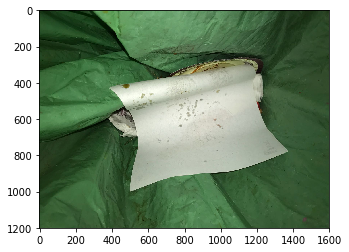

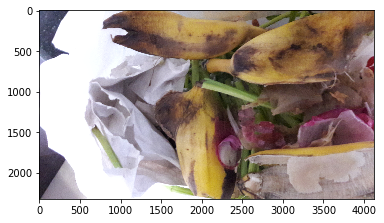

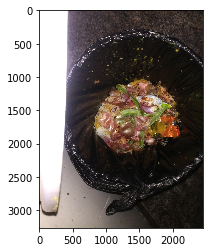

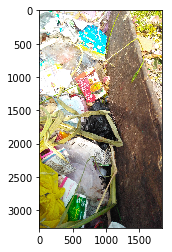

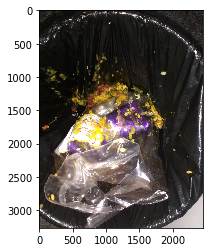

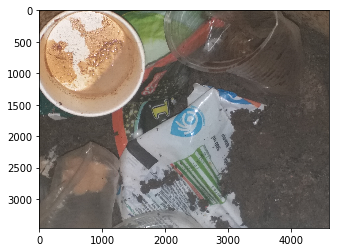

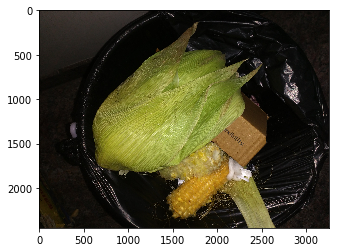

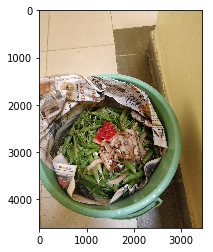

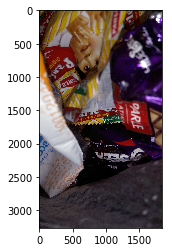

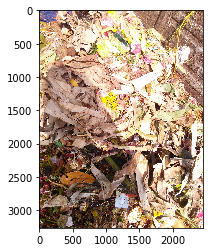

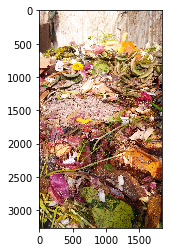

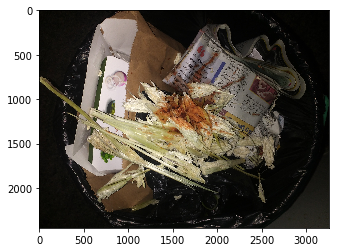

In [36]:
filepath="/opt/swm-ml-docker/images_bak/"
for i in FNImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

    

In [56]:
df = pd.read_csv('Consolidated.csv')
filepath='imageNameFN.txt'
imageName=[]
with open(filepath,'r') as fp:
   for line in fp:
     line =line.strip('\n')
     imageName.append(line)
#print imageName
print df.loc[df['Image Name'].isin(imageName)]

      Serial No Primary Secondary Tertiary              Source Photographer  \
84           85     Dry       Wet      NaN               House      Watsapp   
534         535     Dry       Wet      NaN               House      Pravada   
565         566     Wet       NaN      Dry               House      Pravada   
786         787     Wet       Dry      NaN           Apartment      Pravada   
1084       1085     Dry       Wet      NaN           Apartment      Pravada   
1402       1403     Dry       NaN      NaN               House       Ishani   
1537       1538     Wet       Dry      NaN               House        Ramki   
1949       1950     Wet       NaN      NaN               House         Manu   
2404       2405     Dry       NaN      NaN               House        Manoj   
2494       2495     Wet    Garden      Dry  Collection Vehicle        Manoj   
2525       2526     Dry    Garden      Wet  Collection Vehicle        Manoj   
2614       2615  Garden       Wet      Dry  Collecti